In [1]:
import pandas as pd
import numpy as np
import os

DATA_ROOT = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'data')
NODES = 'nodes_all_raw.csv'

TRAIN_NODES = 'X_train.csv'
VAL_NODES = 'X_val.csv'
TEST_NODES = 'X_test.csv'

process all nodes

In [2]:
features = ['year_of_study', 'participation', 
            'pe_percent', 'finals_percent', 'midterms_percent', 
            'afast', 'level_min_max', 'exp_min_max', 
            't01_exp', 't02_exp', 't03_exp', 't04_exp', 't05_exp', 
            't06_exp', 't07_exp', 't08_exp', 't09_exp', 
            'num_videos', 'avg_videos_completion']

In [3]:
train = pd.read_csv(TRAIN_NODES).set_index('name')
val = pd.read_csv(VAL_NODES).set_index('name')
node_data_test = pd.read_csv(TEST_NODES).set_index('name')
node_data_train = pd.concat([train, val])
node_data_train['y'] = node_data_train['num_confessed_assignments'].apply(lambda x: 1 if x > 0 else 0)
node_data_test['y'] = node_data_test['num_confessed_assignments'].apply(lambda x: 1 if x > 0 else 0)
all_node_data = pd.concat([node_data_train, node_data_test])

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [5]:
train_true = node_data_train[node_data_train['y'] == 1]
print(train_true.shape[0])
train_false = node_data_train[node_data_train['y'] == 0].sample(n=train_true.shape[0])
balanced_node_data = pd.concat([train_true, train_false]).sample(frac=1)
X_train, y_train = balanced_node_data[features], balanced_node_data['y']
X_test, y_test = node_data_test[features], node_data_test['y']
print(X_train.shape, X_test.shape)

131
(262, 19) (103, 19)


## Normalization

In [6]:
from sklearn.preprocessing import MinMaxScaler
normalized = lambda df: pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=df.index)
X_train_normalized, X_test_normalized = normalized(X_train), normalized(X_test)

## Node Potential
### SVM

In [7]:
from sklearn.svm import SVC

In [8]:
svm_1 = SVC(kernel='linear', C=1, random_state=42, probability=True)
svm_scores_1 = cross_val_score(svm_1, X_train_normalized, y_train, cv=5)
print('svm_1', svm_scores_1)

svm_1 [0.66037736 0.64150943 0.73076923 0.59615385 0.69230769]


In [10]:
node_svm = SVC(kernel='linear', C=1, random_state=42, probability=True) \
    .fit(X_train_normalized, y_train)
print(node_svm.score(X_test_normalized, y_test))

0.5145631067961165


In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, node_svm.predict(X_test_normalized))

array([[43, 45],
       [ 5, 10]], dtype=int64)

In [12]:
pred = node_svm.predict_proba(normalized(all_node_data[features]))
pred_df = pd.DataFrame(pred, columns=['0', '1'], index=all_node_data.index)
pred_df['y_pred'] = node_svm.predict(normalized(all_node_data[features]))
pred_df = pred_df.merge(all_node_data['y'], 'inner', 'name')
pred_df['y_obs'] = pred_df.apply(lambda row: row['y'] if row.name in node_data_train.index.to_list() else None, axis=1)
pred_df.to_csv('svm_node_potential.csv')

### GP

In [13]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [14]:
kernel = 1.0 * RBF(1.0)
gpc_1 = GaussianProcessClassifier(kernel=kernel, random_state=42)
gpc_scores = cross_val_score(gpc_1,  X_train_normalized, y_train, cv=5)
print('gpc_1', gpc_scores)

gpc_1 [0.69811321 0.52830189 0.67307692 0.59615385 0.61538462]


In [15]:
node_gpc = GaussianProcessClassifier(kernel=kernel, random_state=42) \
    .fit(X_train_normalized, y_train)
print(node_gpc.score(X_test_normalized, y_test))

0.6116504854368932


In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, node_gpc.predict(X_test_normalized))

array([[54, 34],
       [ 6,  9]], dtype=int64)

In [17]:
pred = node_gpc.predict_proba(normalized(all_node_data[features]))
pred_df = pd.DataFrame(pred, columns=['0', '1'], index=all_node_data.index)
pred_df['y_pred'] = node_gpc.predict(normalized(all_node_data[features]))
pred_df = pred_df.merge(all_node_data['y'], 'inner', 'name')
pred_df['y_obs'] = pred_df.apply(lambda row: row['y'] if row.name in node_data_train.index.to_list() else None, axis=1)
pred_df.to_csv('gpc_node_potential.csv')

### KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_scores_5 = cross_val_score(knn_5,  X_train_normalized, y_train, cv=5)
print('knn_5', knn_scores_5)

knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_scores_10 = cross_val_score(knn_10,  X_train_normalized, y_train, cv=5)
print('knn_10', knn_scores_10)

knn_15 = KNeighborsClassifier(n_neighbors=15)
knn_scores_15 = cross_val_score(knn_15,  X_train_normalized, y_train, cv=5)
print('knn_15', knn_scores_15)

knn_5 [0.58490566 0.45283019 0.63461538 0.61538462 0.61538462]
knn_10 [0.62264151 0.60377358 0.65384615 0.53846154 0.65384615]
knn_15 [0.60377358 0.66037736 0.63461538 0.63461538 0.57692308]


In [19]:
node_knn = KNeighborsClassifier(n_neighbors=15).fit( X_train_normalized, y_train)
print(node_knn.score(X_test_normalized, y_test))

0.6019417475728155


In [20]:
node_knn.score(X_test_normalized, y_test)

0.6019417475728155

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, node_knn.predict(X_test_normalized))

array([[53, 35],
       [ 6,  9]], dtype=int64)

In [21]:
pred = node_knn.predict_proba(normalized(all_node_data[features]))
pred_df = pd.DataFrame(pred, columns=['0', '1'], index=all_node_data.index)
pred_df['y_pred'] = node_knn.predict(normalized(all_node_data[features]))
pred_df = pred_df.merge(all_node_data['y'], 'inner', 'name')
pred_df['y_obs'] = pred_df.apply(lambda row: row['y'] if row.name in node_data_train.index.to_list() else None, axis=1)
pred_df.to_csv('knn_node_potential.csv')

TypeError: plot_confusion_matrix() got an unexpected keyword argument 'fmt'

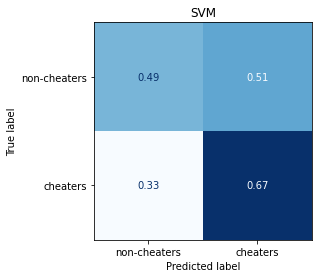

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(node_svm, X_test_normalized, y_test,
                                 display_labels=['non-cheaters', 'cheaters'],
                                 cmap=plt.cm.Blues,
                                 normalize='true', colorbar=False)
disp.ax_.set_title('SVM')
disp = plot_confusion_matrix(node_gpc, X_test_normalized, y_test,
                                 display_labels=['non-cheaters', 'cheaters'],
                                 cmap=plt.cm.Blues,
                                 normalize='true', colorbar=False)
disp.ax_.set_title('GPC')
disp = plot_confusion_matrix(node_knn, X_test_normalized, y_test,
                                 display_labels=['non-cheaters', 'cheaters'],
                                 cmap=plt.cm.Blues,
                                 normalize='true', colorbar=False)
disp.ax_.set_title('KNN')

## Edge Potential

In [22]:
EDGES_UNIQ = os.path.join(DATA_ROOT, 'uniq_lines_edge_weights.csv')
EDGES_MAX = os.path.join(DATA_ROOT, 'max_edge_weights.csv')
EDGES_MIN = os.path.join(DATA_ROOT, 'min_edge_weights.csv')
EDGES_AVG = os.path.join(DATA_ROOT, 'avg_edge_weights.csv')
edges = pd.read_csv(EDGES_MAX)

In [23]:
edge_data = edges.merge(all_node_data[['node_name', 'y']], how='left', left_on='NodeID1', right_on='node_name') \
                    .rename(columns={'y': 'y_1'})

edge_data = edge_data.merge(all_node_data[['node_name', 'y']], how='left', left_on='NodeID2', right_on='node_name') \
                    .rename(columns={'y': 'y_2'}).drop(['node_name_x', 'node_name_y'], axis=1)

def get_distance(node_name_1, node_name_2, df, features):
    return np.linalg.norm(df.loc[node_name_1][features] - df.loc[node_name_2][features])

def get_dot(node_name_1, node_name_2, df, features):
    return np.dot(df.loc[node_name_1][features], df.loc[node_name_2][features])

edge_data['distance'] = edge_data.apply(lambda row: get_distance(row['NodeID1'], row['NodeID2'], normalized(all_node_data[features]), features), axis=1)
edge_data['dot'] = edge_data.apply(lambda row: get_dot(row['NodeID1'], row['NodeID2'], normalized(all_node_data[features]), features), axis=1)

edge_data['y'] = edge_data.apply(lambda row: row['y_1'] + row['y_2'], axis=1)
edge_data['yy'] = edge_data.apply(lambda row: str(row['y_1']) + str(row['y_2']), axis=1)

edge_train = edge_data.merge(node_data_train[['node_name']], how='inner', left_on='NodeID1', right_on='node_name')[edge_data.columns]
edge_train = edge_train.merge(node_data_train[['node_name']], how='inner', left_on='NodeID2', right_on='node_name')[edge_data.columns]

edge_data = edge_data.set_index(['NodeID1', 'NodeID2'])
edge_train = edge_train.set_index(['NodeID1', 'NodeID2'])

edge_train

,,edge_weights,y_1,y_2,distance,dot,y,yy
NodeID1,NodeID2,,,,,,,
aaron_christian,marc_key,0.011343,1,1,1.133242,8.054074,2,11
david_atkinson,marc_key,0.017403,1,1,0.700736,8.117675,2,11
grace_roberts,marc_key,0.009837,0,1,0.840199,8.953398,1,01
james_black,marc_key,0.017092,0,1,0.766260,9.565469,1,01
john_stewart,marc_key,0.017520,0,1,0.562269,9.125641,1,01
...,...,...,...,...,...,...,...,...
william_marks,caitlin_rodriguez,0.009006,0,0,1.521762,7.440076,0,00
william_meyers,dominique_shaffer,0.020980,0,1,1.497580,5.412665,1,01
william_moreno,sheila_medina,0.014044,1,0,1.964118,6.255026,1,10


In [24]:
min_count = edge_train['y'].value_counts().min()
edge_data_0 = edge_train[edge_train['y'] == 0].sample(n=min_count)
edge_data_1 = edge_train[edge_train['y'] == 1].sample(n=min_count)
edge_data_2 = edge_train[edge_train['y'] == 2].sample(n=min_count)

balanced_edge_data = pd.concat([edge_data_0, edge_data_1, edge_data_2]).sample(frac=1)

edge_features = ['edge_weights', 'distance', 'dot']
edge_X, edge_y = balanced_edge_data[edge_features], balanced_edge_data['y']
print(edge_X.shape, edge_y.shape, edge_y.mean())

(255, 3) (255,) 1.0


### GP

In [25]:
kernel = 1.0 * RBF(1.0)
gpc_1 = GaussianProcessClassifier(kernel=kernel, random_state=42)
gpc_scores = cross_val_score(gpc_1, edge_X, edge_y, cv=5)
print('gpc_1', gpc_scores)

gpc_1 [0.41176471 0.49019608 0.41176471 0.52941176 0.43137255]


In [26]:
gpc = GaussianProcessClassifier(kernel=kernel, random_state=42).fit(edge_X, edge_y)
print(gpc.score(edge_data[edge_features], edge_data['y']))

0.4452317685267198


In [27]:
pred = gpc.predict_proba(edge_data[edge_features])
pred_df = pd.DataFrame(pred, columns=['0', '1', '2'], index=edge_data.index)
pred_df.to_csv('gpc_edge_potential.csv')

### KNN

In [28]:
edge_knn_5 = KNeighborsClassifier(n_neighbors=5)
edge_knn_scores_5 = cross_val_score(edge_knn_5, edge_X, edge_y, cv=5)
print('knn_5', edge_knn_scores_5)

edge_knn_10 = KNeighborsClassifier(n_neighbors=10)
edge_knn_scores_10 = cross_val_score(edge_knn_10, edge_X, edge_y, cv=5)
print('knn_10', edge_knn_scores_10)

edge_knn_15 = KNeighborsClassifier(n_neighbors=15)
edge_knn_scores_15 = cross_val_score(knn_15, edge_X, edge_y, cv=5)
print('knn_15', edge_knn_scores_15)

knn_5 [0.43137255 0.43137255 0.23529412 0.47058824 0.41176471]
knn_10 [0.35294118 0.41176471 0.33333333 0.49019608 0.47058824]
knn_15 [0.37254902 0.52941176 0.41176471 0.52941176 0.50980392]


In [29]:
edge_knn = KNeighborsClassifier(n_neighbors=15).fit(edge_X, edge_y)
print(edge_knn.score(edge_data[edge_features], edge_data['y']))

0.44936521995866546


In [30]:
pred = edge_knn.predict_proba(edge_data[edge_features])
pred_df = pd.DataFrame(pred, columns=['0', '1', '2'], index=edge_data.index)
pred_df.to_csv('knn_edge_potential.csv')

## Run main

In [37]:
node_type, edge_type = 'knn', 'gpc'
marginals = pd.read_csv('%s_%s_marginals.csv' % (node_type, edge_type))
marginals = marginals.merge(all_node_data[['node_name', 'y']], 'left', left_on='name', right_on='node_name')

obs = pd.read_csv('%s_node_potential.csv' % node_type)[['name', 'y_obs']]
marginals = marginals.merge(obs, 'left', 'name')

marginals[['name', 'y_pred', 'y_obs', 'y']] \
    .sort_values(['y_pred', 'y_obs', 'y'], ascending=[False, False, False]) \
    .to_csv('%s_%s_results.csv' % (node_type, edge_type), index=False)

In [38]:
test_results = marginals[marginals['y_obs'].isnull()]
confusion_matrix(test_results['y'], [1 if y > 0.5 else 0 for y in test_results['y_pred']])

array([[76, 12],
       [12,  3]], dtype=int64)